In [1]:
import numpy as np
import Loader
import Transformer

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
#note loading data also shuffles order of the data
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

### Notes on Principal Component Analysis

Does it make sense to run PCA on like-type parts of the data?
As there are clearly different "sets" of the data per row.

In [4]:
#for i in range(len(labelsTrain)):
#    print(i, '\b:\t', labelsTrain[i], compoundDataTrain[35:40, i])
    
#for all the following ranges begin is inclusive and end is not inclusive
#[0:10] docking_score_? (0-9)
#[10:20] fusion_score_? (0-9)
#[37:45] bcut2d_? (8 in total)
#[47:59] chi? (12, odd labels)
#[65:79] paoe_vsa? (1-14)
#[79:89] smr_vsa? (1-10)
#[89:101] slogp_vsa? (1-12)
#[102:113] estate_vsa? (1-11)
#[113:123] vsa_estate? (1-10)
#[143:228] fr_some_chemical? (85 total)

#print(labelsTrain[0:10],"\n")
#print(labelsTrain[10:20],"\n")
#print(labelsTrain[37:45],"\n")
#print(labelsTrain[47:59],"\n")
#print(labelsTrain[65:79],"\n")
#print(labelsTrain[79:89],"\n")
#print(labelsTrain[89:101],"\n")
#print(labelsTrain[102:113],"\n")
#print(labelsTrain[113:123],"\n")
#print(labelsTrain[143:228],"\n")

## Data Preprocessing
PCA, modify fusion/docking, normalization

### Apply Principal Component Analysis

In [3]:
#reduce dimension through PCA
#in order endDims sections are chi, paoe, smr, slogp, estate_vsa, vsa_estate, fr
labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,4,4,3,3,3,3])
print("PCA done, new dimensions:", len(labelsPCA))

bcut2d retention: [0.99364773]
	total: 99.36477273412319%
chi retention: [0.9541968]
	total: 95.419679685979%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179]
	total: 73.74304791821314%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840067%
slogp retention: [0.44620276 0.22134465 0.15753302]
	total: 82.50804204396219%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.55013868306435%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216797%
fr retention: [0.32153498 0.12578177 0.09944384]
	total: 54.676059360511594%
PCA done, new dimensions: 88


### Use either mean or max magnitude of docking and fusion

Actually quite similar e.g. for the first 3 rows:

fusion max:  $[5.3211, 5.3258, 5.3936]$

fusion avg:  $[5.0530, 5.2303, 5.1805]$

docking max: $[6.7, 7.2, 7.3]$

docking avg: $[-6.51, -6.92, -7.18]$

In [4]:
#use mean of the docking and fusion
labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)
print("Mean of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Mean of Fusion and Docking, new dimensions:  70


In [5]:
#use max magnitude of the docking and fusion
labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)
print("Max of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Max of Fusion and Docking, new dimensions:  70


### Assign final data and normalize data

In [11]:
#after transformations are done assign data
dataLabels = labelsMeanPCA
trainData = trainMeanPCA
testData = testMeanPCA
valData = valMeanPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

## See modified labels and example data:

In [12]:
print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

(2717, 70)
0 :	 docking_score_average 	 [ 1.1074388  -0.52330849  0.12670966]
1 :	 fusion_score_average 	 [-1.79853452  0.21157186  0.29241926]
2 :	 maxestateindex 	 [-0.95121222  0.30073201  0.29534824]
3 :	 minestateindex 	 [ 0.53993143 -0.92493742  0.76948205]
4 :	 maxabsestateindex 	 [-0.95121222  0.30073201  0.29534824]
5 :	 minabsestateindex 	 [ 0.12021677 -0.18543898 -0.52992845]
6 :	 qed 	 [ 1.00128251  0.57913769 -0.98619554]
7 :	 molwt 	 [-0.87430204 -0.00179165  0.25777004]
8 :	 heavyatommolwt 	 [-0.84829949  0.04170188  0.32007232]
9 :	 exactmolwt 	 [-0.87627309 -0.0039833   0.25828844]
10 :	 numvalenceelectrons 	 [-1.00433463 -0.18773438 -0.0587975 ]
11 :	 numradicalelectrons 	 [0. 0. 0.]
12 :	 maxpartialcharge 	 [-0.01918824 -0.01918824 -0.01918824]
13 :	 minpartialcharge 	 [-0.90218283  1.12765238  0.42473688]
14 :	 maxabspartialcharge 	 [-0.01918824 -0.01918824 -0.01918824]
15 :	 minabspartialcharge 	 [-0.19771544 -0.74871513 -0.31484552]
16 :	 fpdensit

# Apply NN

In [13]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [14]:
#note the constant guess:
classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)
print(constantGuess)

0.6198012513801987


In [26]:
classTrain = Transformer.toClassification(activitiesTrain)
classVal = Transformer.toClassification(activitiesValidate)


optimizer = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
)
l1Reg = 1e-10

model = Sequential()
model.add(Dense(100, input_dim=np.shape(trainData)[1], activation='tanh', 
                kernel_regularizer = keras.regularizers.L2(l1Reg)))
model.add(Dense(200, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(300, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(250, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(200, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(100, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(50, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(30, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(10, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(l1Reg)))

model.compile(loss='MeanSquaredError', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(trainData, Transformer.toClassification(activitiesTrain), 
                    validation_data = (valData, classVal), epochs=1600, batch_size=4)

Epoch 1/1600
680/680 [==============================] - 5s 5ms/step - loss: 0.6945 - accuracy: 0.1833 - val_loss: 0.4942 - val_accuracy: 0.4059
Epoch 2/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.4172 - accuracy: 0.4630 - val_loss: 0.4049 - val_accuracy: 0.4324
Epoch 3/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.3468 - accuracy: 0.4925 - val_loss: 0.3697 - val_accuracy: 0.4912
Epoch 4/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.3095 - accuracy: 0.5042 - val_loss: 0.3515 - val_accuracy: 0.4912
Epoch 5/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.2861 - accuracy: 0.5193 - val_loss: 0.3435 - val_accuracy: 0.4912
Epoch 6/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.2649 - accuracy: 0.5223 - val_loss: 0.3244 - val_accuracy: 0.5059
Epoch 7/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.2444 - accuracy: 0.5267 - val_loss: 0.3294 - val_accuracy:

680/680 [==============================] - 2s 4ms/step - loss: 0.0250 - accuracy: 0.6146 - val_loss: 0.2962 - val_accuracy: 0.5412
Epoch 58/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0246 - accuracy: 0.6139 - val_loss: 0.2991 - val_accuracy: 0.5441
Epoch 59/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0233 - accuracy: 0.6143 - val_loss: 0.3058 - val_accuracy: 0.5559
Epoch 60/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0229 - accuracy: 0.6150 - val_loss: 0.2953 - val_accuracy: 0.5382
Epoch 61/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0223 - accuracy: 0.6146 - val_loss: 0.2975 - val_accuracy: 0.5382
Epoch 62/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0219 - accuracy: 0.6150 - val_loss: 0.2981 - val_accuracy: 0.5412
Epoch 63/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0215 - accuracy: 0.6165 - val_loss: 0.3002 - val_accuracy: 0.5471

680/680 [==============================] - 2s 3ms/step - loss: 0.0171 - accuracy: 0.6172 - val_loss: 0.3010 - val_accuracy: 0.5500
Epoch 114/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0171 - accuracy: 0.6172 - val_loss: 0.3018 - val_accuracy: 0.5500
Epoch 115/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0171 - accuracy: 0.6172 - val_loss: 0.3016 - val_accuracy: 0.5500
Epoch 116/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0171 - accuracy: 0.6172 - val_loss: 0.3013 - val_accuracy: 0.5500
Epoch 117/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0170 - accuracy: 0.6172 - val_loss: 0.3020 - val_accuracy: 0.5500
Epoch 118/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0170 - accuracy: 0.6172 - val_loss: 0.3012 - val_accuracy: 0.5500
Epoch 119/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0170 - accuracy: 0.6172 - val_loss: 0.3028 - val_accuracy: 

680/680 [==============================] - 2s 3ms/step - loss: 0.0139 - accuracy: 0.6176 - val_loss: 0.3084 - val_accuracy: 0.5500
Epoch 170/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0139 - accuracy: 0.6176 - val_loss: 0.3098 - val_accuracy: 0.5529
Epoch 171/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0139 - accuracy: 0.6176 - val_loss: 0.3090 - val_accuracy: 0.5529
Epoch 172/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0139 - accuracy: 0.6176 - val_loss: 0.3105 - val_accuracy: 0.5529
Epoch 173/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0139 - accuracy: 0.6176 - val_loss: 0.3100 - val_accuracy: 0.5529
Epoch 174/1600
680/680 [==============================] - 2s 3ms/step - loss: 0.0138 - accuracy: 0.6176 - val_loss: 0.3086 - val_accuracy: 0.5529
Epoch 175/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0138 - accuracy: 0.6176 - val_loss: 0.3092 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0124 - accuracy: 0.6176 - val_loss: 0.3000 - val_accuracy: 0.5618
Epoch 226/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0123 - accuracy: 0.6180 - val_loss: 0.2942 - val_accuracy: 0.5559
Epoch 227/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0122 - accuracy: 0.6180 - val_loss: 0.2947 - val_accuracy: 0.5559
Epoch 228/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0121 - accuracy: 0.6180 - val_loss: 0.2970 - val_accuracy: 0.5588
Epoch 229/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0121 - accuracy: 0.6180 - val_loss: 0.2945 - val_accuracy: 0.5588
Epoch 230/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0121 - accuracy: 0.6180 - val_loss: 0.2949 - val_accuracy: 0.5588
Epoch 231/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0120 - accuracy: 0.6180 - val_loss: 0.2947 - val_accuracy: 

680/680 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2968 - val_accuracy: 0.5588
Epoch 282/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2961 - val_accuracy: 0.5588
Epoch 283/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2965 - val_accuracy: 0.5588
Epoch 284/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2958 - val_accuracy: 0.5588
Epoch 285/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2965 - val_accuracy: 0.5588
Epoch 286/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2965 - val_accuracy: 0.5588
Epoch 287/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0105 - accuracy: 0.6183 - val_loss: 0.2963 - val_accuracy: 

680/680 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2975 - val_accuracy: 0.5588
Epoch 338/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2973 - val_accuracy: 0.5588
Epoch 339/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2976 - val_accuracy: 0.5588
Epoch 340/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2977 - val_accuracy: 0.5588
Epoch 341/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2979 - val_accuracy: 0.5588
Epoch 342/1600
680/680 [==============================] - 2s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2978 - val_accuracy: 0.5588
Epoch 343/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2979 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2988 - val_accuracy: 0.5588
Epoch 394/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2991 - val_accuracy: 0.5588
Epoch 395/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2990 - val_accuracy: 0.5588
Epoch 396/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2991 - val_accuracy: 0.5588
Epoch 397/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2987 - val_accuracy: 0.5588
Epoch 398/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2987 - val_accuracy: 0.5588
Epoch 399/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0104 - accuracy: 0.6183 - val_loss: 0.2986 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0090 - accuracy: 0.6187 - val_loss: 0.3032 - val_accuracy: 0.5559
Epoch 450/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3029 - val_accuracy: 0.5559
Epoch 451/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3027 - val_accuracy: 0.5559
Epoch 452/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3028 - val_accuracy: 0.5559
Epoch 453/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3027 - val_accuracy: 0.5559
Epoch 454/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3027 - val_accuracy: 0.5559
Epoch 455/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0089 - accuracy: 0.6187 - val_loss: 0.3031 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3049 - val_accuracy: 0.5559
Epoch 506/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 507/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 508/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 509/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 510/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 511/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.6187 - val_loss: 0.3049 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3044 - val_accuracy: 0.5559
Epoch 562/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3044 - val_accuracy: 0.5559
Epoch 563/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3044 - val_accuracy: 0.5559
Epoch 564/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3043 - val_accuracy: 0.5559
Epoch 565/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3043 - val_accuracy: 0.5559
Epoch 566/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3043 - val_accuracy: 0.5559
Epoch 567/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 618/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 619/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 620/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 621/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 622/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 623/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 674/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 675/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 676/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 677/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 678/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 679/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 730/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 731/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 732/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 733/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 734/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 735/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 786/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 787/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 788/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 789/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 790/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 791/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 842/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 843/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 844/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 845/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 846/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 847/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 

680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 898/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 899/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 900/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 901/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 902/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 903/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 

680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 954/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 955/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 956/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 957/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 958/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 0.5559
Epoch 959/1600
680/680 [==============================] - 3s 4ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3042 - val_accuracy: 

680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1010/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1011/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1012/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1013/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1014/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1015/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accu

Epoch 1065/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1066/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1067/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1068/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1069/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3041 - val_accuracy: 0.5559
Epoch 1070/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1071/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1121/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1122/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1123/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1124/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1125/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1126/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1127/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1177/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1178/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1179/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1180/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1181/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1182/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1183/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1233/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3039 - val_accuracy: 0.5559
Epoch 1234/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1235/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1236/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1237/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1238/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3040 - val_accuracy: 0.5559
Epoch 1239/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1289/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1290/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1291/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1292/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1293/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1294/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3038 - val_accuracy: 0.5559
Epoch 1295/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1345/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3033 - val_accuracy: 0.5559
Epoch 1346/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3032 - val_accuracy: 0.5559
Epoch 1347/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3032 - val_accuracy: 0.5559
Epoch 1348/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3032 - val_accuracy: 0.5559
Epoch 1349/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3032 - val_accuracy: 0.5559
Epoch 1350/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0.3031 - val_accuracy: 0.5559
Epoch 1351/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0074 - accuracy: 0.6187 - val_loss: 0

Epoch 1401/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1402/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1403/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1404/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1405/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1406/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3045 - val_accuracy: 0.5559
Epoch 1407/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0

Epoch 1457/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1458/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1459/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1460/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1461/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1462/1600
680/680 [==============================] - 3s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3048 - val_accuracy: 0.5559
Epoch 1463/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0

Epoch 1513/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3051 - val_accuracy: 0.5559
Epoch 1514/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3051 - val_accuracy: 0.5559
Epoch 1515/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3051 - val_accuracy: 0.5559
Epoch 1516/1600
680/680 [==============================] - 4s 6ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3051 - val_accuracy: 0.5559
Epoch 1517/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 1518/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3050 - val_accuracy: 0.5559
Epoch 1519/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0

Epoch 1569/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1570/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1571/1600
680/680 [==============================] - 4s 6ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1572/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1573/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1574/1600
680/680 [==============================] - 4s 5ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0.3052 - val_accuracy: 0.5559
Epoch 1575/1600
680/680 [==============================] - 4s 6ms/step - loss: 0.0059 - accuracy: 0.6187 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


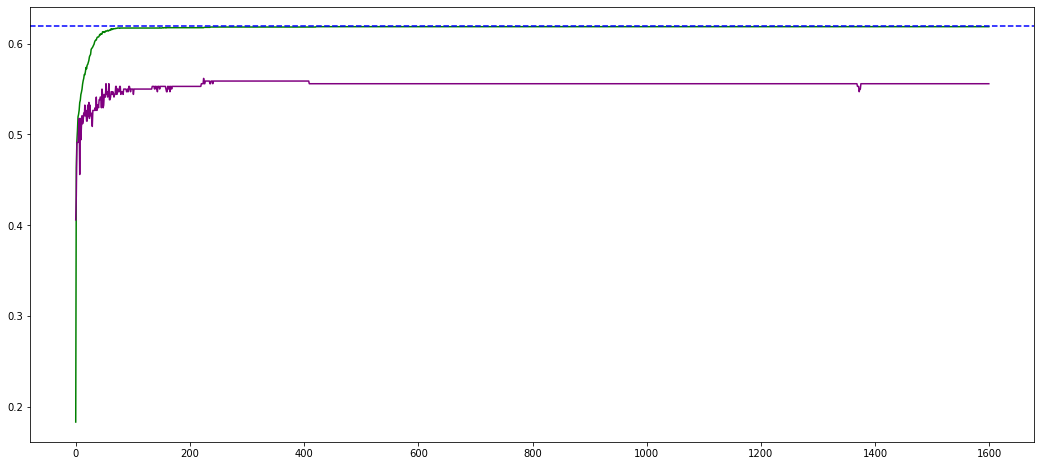

In [27]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")

In [73]:
classData = Transformer.toClassification(activitiesTrain)
print(len(trainData))
print(len(classData[classData == 1]))
print(len(classData[classData != 1]))

2717
1684
1033
